# Recurrent Neural Networks

[**Recurrent neural networks (RNN)**](https://en.wikipedia.org/wiki/Recurrent_neural_network) is a powerful class of neural networks designed to model **dependence** among the sequence input variables. Such sequence dependence occurs in a number of tasks such as time seires prediction, speech recogonition, and machine translation. 


[**Long Short-Term Memory (LSTM)**](https://en.wikipedia.org/wiki/Long_short-term_memory) networks is a special type of RNN architectures that were developed to overcome some training issues of traditional recurrent neural networks. LSTM was proposed by Hochreiter and Schmidhuber in 1997. This notebook will demonstrate how to do time series forecasting using a LSTM model.

## Basics

### Diagram of Traditional RNN


The diagram illustrates how a RNN layer works

<img src='RNN.png' width = '400'>


- $x_t$: input at time $t$; $h_t$: hidden state at time $t$; $o_t$: output at time $t$.

- At time step $t$, the RNN cell will only process one input variable $x_t$, e.g., the $t$-th word from a sample of sentence. 

- The hidden state $s_t$  stores the  memory of RNN which captures the information about what happened in  all the previous stages.

- The same set of trainable weight matrices $(U, V, W)$ are **shared across all layers** to perform the  same task with different inputs.
  * $U$ transforms the input $x_t$ before feeding into the current hidden state $h_t$

  * $W$ transforms the previous state $h_{t-1}$ before feeding into state $h_t$

  * $V$ maps the computed hidden state $h_t$ to the output $o_t$ 
  
### Forward Pass

The the hidden state $s_t$ and output $o_t$ are computed iteratively by:

\begin{align}
& h_{t} = \sigma_h (W h_{t-1} + U x_{t} + b_h)\\
& o_{t} = \sigma_o (V h_t +b_o)
\end{align}

where $b_h$ and $b_o$ denote trainable bias vectors; $\sigma_h$ and $\sigma_o$ are activation functions. $\sigma_h$ is the hyperbolic tangent $\tanh$ function (as shown in the diagram); $\sigma_o$ is sigmoid function.

### Vanishing/Exploding Gradient

The vanishing and exploding gradient phenomena are often encountered in training of RNN. The reason why they happen is that multiplicative gradient resulting from the composition can be exponentially decreasing/increasing with respect to the number of layers. So traditional RNN cannot handle well long term dependencies and relations among input variables.


### Long-Short Term Memory

LSTM can prevent the gradient from vanishing or exploding by using the so-called “forget gates”. 

<img src='LSTM.png' width = '400'>

$\{W_l,U_l,b_l\}_{l = f,i,o,c}$ are trainable parameters shared across all LSTM layers.

Forward pass of an LSTM layer with a forget gate is:

\begin{align}
& f_t = \sigma_g(W_f x_t + U_f h_{t-1} + b_f) \\
& i_t = \sigma_g(W_i x_t + U_i h_{t-1} + b_i) \\
& o_t = \sigma_g(W_o x_t + U_o h_{t-1} + b_o) \\
& \tilde{c}_t = \sigma_c(W_c x_t + U_c h_{t-1} + b_c) \\
& c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \\
& h_t = o_t \odot \sigma_h(c_t)
\end{align}

* $i$: input gate

* $o$: output gate 

* $f$: forget gate

* $c$: memory cell

* $\sigma_g$ is sigmoid, $\sigma_c$ and $\sigma_h$ are both $\tanh$. $\odot$ is entry-wise multiplication.

The long term dependencies and relations are encoded in the memory cell $c$, and it is the cell state derivative that can prevent the LSTM gradients from vanishing or exploding.

### Input-Output Styles

<img src='output.png' width = '800'>

1. **one-to-one**: vanilla mode of processing without RNN, from fixed-sized input to fixed-sized output (e.g. image classification). 

2. **one-to-many**: sequence output (e.g. image captioning takes an image and outputs a sentence of words). 

3. **many-to-one**: sequence input (e.g. temperature prediction in this notebook). 

4. **many-to-many**: sequence input and sequence output (e.g. Machine Translation: an RNN reads a sentence in English and then outputs a sentence in Chinese). 

Notice that in every case are no pre-specified constraints on the lengths sequences because the recurrent transformation (green) is fixed and can be applied as many times as we like.

## Temperature Prediction

**This example requires TensorFlow 2.3 or higher.**

We will be using Jena Climate dataset recorded by the
[Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/).
The dataset consists of 14 features such as temperature, pressure, humidity etc, recorded once per
10 minutes.

**Location**: Weather Station, Max Planck Institute for Biogeochemistry
in Jena, Germany

**Time-frame Considered**: Jan 10, 2009 - December 31, 2016


The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
df = pd.read_csv("jena_climate_2009_2016.csv")

In [3]:
df.head(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
Date Time          420551 non-null object
p (mbar)           420551 non-null float64
T (degC)           420551 non-null float64
Tpot (K)           420551 non-null float64
Tdew (degC)        420551 non-null float64
rh (%)             420551 non-null float64
VPmax (mbar)       420551 non-null float64
VPact (mbar)       420551 non-null float64
VPdef (mbar)       420551 non-null float64
sh (g/kg)          420551 non-null float64
H2OC (mmol/mol)    420551 non-null float64
rho (g/m**3)       420551 non-null float64
wv (m/s)           420551 non-null float64
max. wv (m/s)      420551 non-null float64
wd (deg)           420551 non-null float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


## Raw Data Visualization

To give us a sense of the data we are working with, each feature has been plotted below.
This shows the distinct pattern of each feature over the time period from 2009 to 2016.
It also shows where anomalies are present, which will be addressed during normalization.

In [5]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"

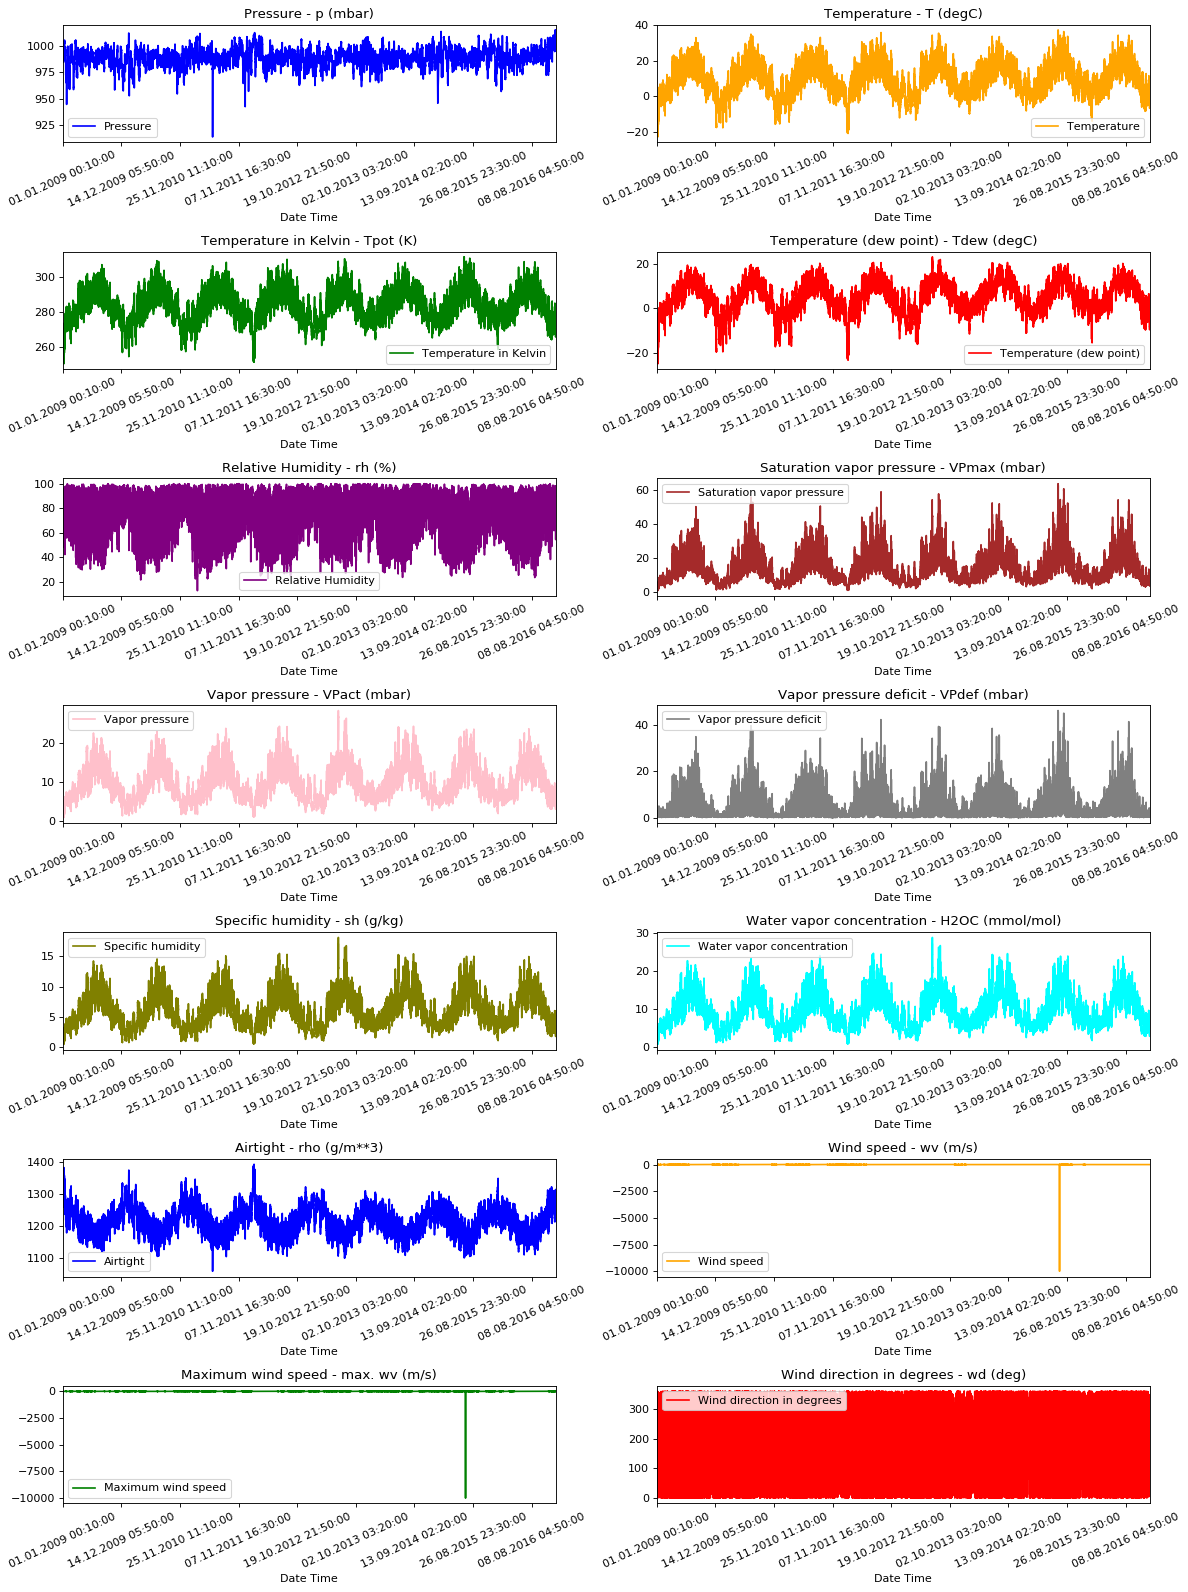

In [6]:
def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]], loc = 0)
    plt.tight_layout()


show_raw_visualization(df)

This heat map shows the correlation between different features.

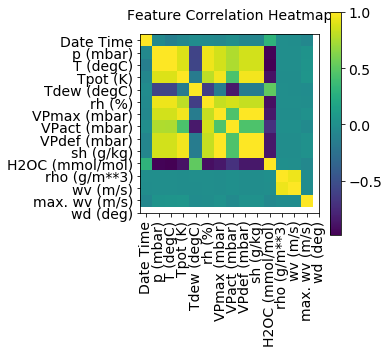

In [7]:
def show_heatmap(data):
    
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
    
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)


show_heatmap(df)

## Data Preprocessing



#### Normalization

Since every feature has values with
varying ranges, we do normalization to confine feature values to a range of `[0, 1]` before
training a neural network.
We do this by subtracting the mean and dividing by the standard deviation of each feature.

#### Data Splitting

71.5 % of the data will be used to train the model, i.e. 300,693 rows. `split_fraction` can
be changed to alter this percentage.


#### Resampling Hourly Data

Observation is recorded every
10 mins, that means 6 times per hour. We will resample one point per hour since no
drastic change is expected within 60 minutes. We do this via the `sampling_rate`
argument in `timeseries_dataset_from_array` utility.

We are tracking data from past 720 timestamps (720/6=120 hours = 5 days). This data will be
used to predict the temperature after 72 timestamps (72/6=12 hours).

The model is shown data for first 5 days i.e. 720 observations, that are sampled every
hour. The temperature after 72 (12 hours * 6 observation per hour) observations will be
used as a label.

We can see from the correlation heatmap, few parameters like Relative Humidity and
Specific Humidity are redundant. Hence we will be using select features, not all.

### Training Set

The training dataset labels starts from the 792nd observation (720 + 72).

In [8]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [9]:
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head(10)

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
Date Time,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,3.33,0.22,1.94,1307.75,1.03
01.01.2009 00:20:00,996.57,-8.41,3.23,0.21,1.89,1309.80,0.72
01.01.2009 00:30:00,996.53,-8.51,3.21,0.20,1.88,1310.24,0.19
01.01.2009 00:40:00,996.51,-8.31,3.26,0.19,1.92,1309.19,0.34
01.01.2009 00:50:00,996.51,-8.27,3.27,0.19,1.92,1309.00,0.32
01.01.2009 01:00:00,996.50,-8.05,3.33,0.19,1.96,1307.86,0.21
01.01.2009 01:10:00,996.50,-7.62,3.44,0.18,2.04,1305.68,0.18
01.01.2009 01:20:00,996.50,-7.62,3.44,0.19,2.03,1305.69,0.19
01.01.2009 01:30:00,996.50,-7.91,3.36,0.21,1.97,1307.17,0.28


In [10]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [11]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
print(train_split)

300693


In [12]:
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head(10)

,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944
5,0.953020,-2.003494,-1.319782,-0.794724,-1.493489,2.240351,-1.269978
6,0.953020,-1.953697,-1.305455,-0.796806,-1.463739,2.186990,-1.289624
7,0.953020,-1.953697,-1.305455,-0.794724,-1.467458,2.187234,-1.283076
8,0.953020,-1.987281,-1.315874,-0.790561,-1.489770,2.223461,-1.224139
9,0.956666,-2.047501,-1.332806,-0.788479,-1.523239,2.289062,-1.021134


In [13]:
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [14]:
past = 720
future = 72
step = 6

start = past + future # 792
end = start + train_split # 792 + 300693

x_train = train_data.values
y_train = features.iloc[start:end][1] # take column 'T' as label

sequence_length = int(past / step)
print('Sequence length: ', sequence_length)

Sequence length:  120


The `timeseries_dataset_from_array` function takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as length of the
sequences/windows `sequence_length`, spacing between two sequence/windows, etc., to produce batches of
sub-timeseries inputs and targets sampled from the main timeseries.

In [15]:
batch_size = 256

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

### Validation Set

The validation dataset must not contain the last 792 rows as we won't have labelled data for
those records, hence 792 must be subtracted from the end of the data.

The validation label dataset must start from 792 after train_split, hence we must add
past + future (792) to label_start.

In [16]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end].values
y_val = features.iloc[label_start:][1]


dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256,)


### Build LSTM Model

[`keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) implements LSTM. The argument `units = 32` is the dimension of output. `return_sequences` determines whether to return the last output in the output sequence or to return the full sequence. 
We choose the default value of `False` since our LSTM is **many-to-one**.

One top of that, we add a `Dense` layer to transform the 32-dimensional output from `LSTM` into a scalar, i.e., the predicted temperature.

In addtion, we wse the `Adam` optimizer and mean squared loss `mse` for `complie` function.

In [20]:
from keras.models import Sequential
from keras.layers import Dense, LSTM


def lstm_dense():
  model = Sequential()
  model.add(LSTM(units = 32, input_shape = (120,7)))
  model.add(Dense(units = 1))
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
  return model

### Training

We'll use the `ModelCheckpoint` callback to regularly save checkpoints, and
the `EarlyStopping` callback to interrupt training when the validation loss
is not improving for `patience=7` consecutive epochs.

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [18]:
path_checkpoint = "model_checkpoint.h5"
es_callback = EarlyStopping(monitor="val_loss", patience=7)

modelckpt_callback = ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)


model = lstm_dense()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5120      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(
    dataset_train,
    epochs = 40,
    validation_data = dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/40
1172/1172 [==============================] - 79s 66ms/step - loss: 0.1819 - val_loss: 0.1452

Epoch 00001: val_loss improved from inf to 0.14518, saving model to model_checkpoint.h5
Epoch 2/40
1172/1172 [==============================] - 82s 70ms/step - loss: 0.1232 - val_loss: 0.1431

Epoch 00002: val_loss improved from 0.14518 to 0.14311, saving model to model_checkpoint.h5
Epoch 3/40
1172/1172 [==============================] - 87s 74ms/step - loss: 0.1134 - val_loss: 0.1502

Epoch 00003: val_loss did not improve from 0.14311
Epoch 4/40
1172/1172 [==============================] - 81s 69ms/step - loss: 0.1098 - val_loss: 0.1488

Epoch 00004: val_loss did not improve from 0.14311
Epoch 5/40
1172/1172 [==============================] - 76s 65ms/step - loss: 0.1068 - val_loss: 0.1433

Epoch 00005: val_loss did not improve from 0.14311
Epoch 6/40
1172/1172 [==============================] - 76s 64ms/step - loss: 0.1050 - val_loss: 0.1375

Epoch 00006: val_loss improved from 0

We can visualize the history of loss below. 

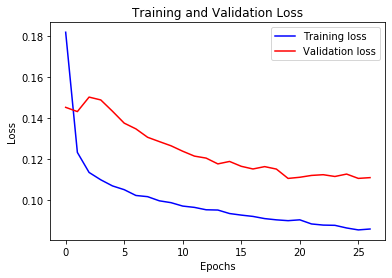

In [21]:
def plot_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_loss(history, "Training and Validation Loss")

### Prediction

The trained model above is now able to make predictions for 5 sets of values from
validation set.

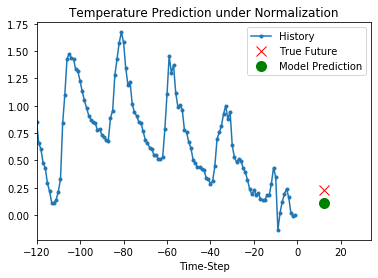

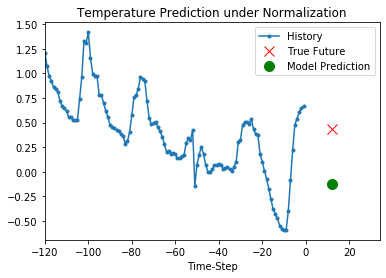

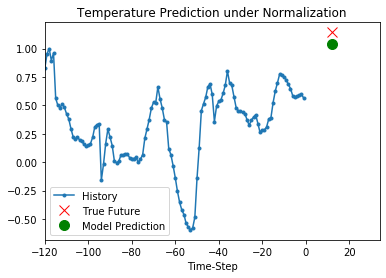

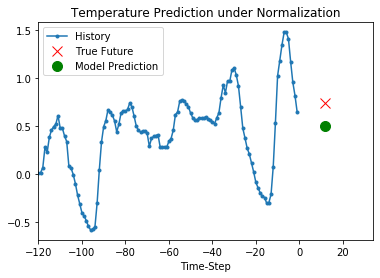

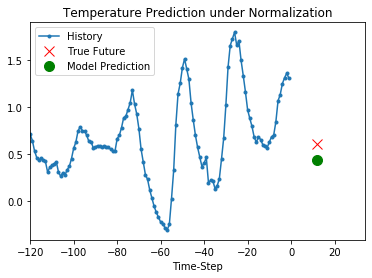

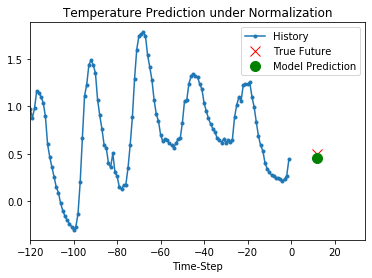

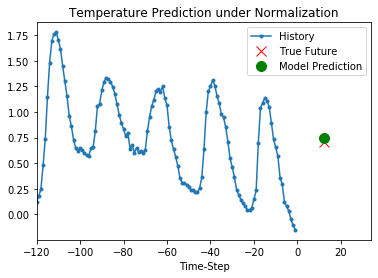

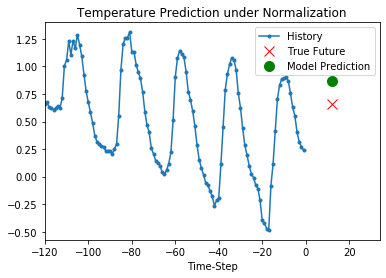

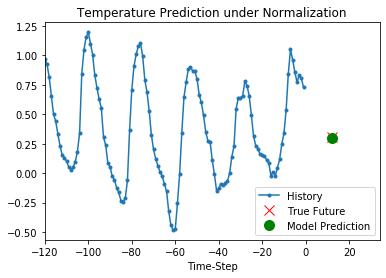

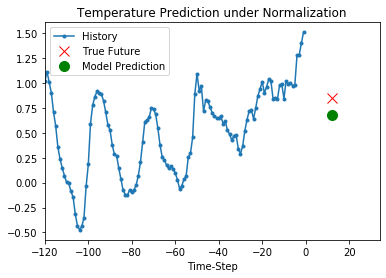

In [23]:
def plot_prediction(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(10):
    plot_prediction(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Temperature Prediction under Normalization",
    )